<a href="https://colab.research.google.com/github/hossein20s/aBinaryClassification/blob/master/Tempus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition
Check it out from https://drive.google.com/file/d/0B2N190SEI1grNXRxRjN5NWdkWWVHSzZyNWN5bWJNNUo3T3BF/view?usp=drivesdk


# Initialize
Connecting colab to GDrive as I kept the data there

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/data" data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link 'data/data': Function not implemented


In [0]:
!gunzip data/DScasestudy.txt.gz
!wc -l data/DScasestudy.txt

gzip: data/DScasestudy.txt.gz: No such file or directory
531 data/DScasestudy.txt


# Data Inspactoin

Conver it to Pandas Dataframe and check it’s shape

In [0]:
DATA_FILE = 'data/DScasestudy.txt'
import pandas as pd

data = pd.read_csv(DATA_FILE, sep="\t")
print(data.shape)

(530, 16563)


*  Take a look at the first couple of lines 
*  If it has any missing data: *It didn’t*
*  Some statistics on the data: *Sparse data*




In [0]:
print(data.iloc[1:3,0:4])
print(data.isnull().values.any())
print(data.describe())

   response  V1  V2  V3
1         1   0   0   0
2         1   0   0   0
False
         response          V1          V2  ...      V16560  V16561      V16562
count  530.000000  530.000000  530.000000  ...  530.000000   530.0  530.000000
mean     0.232075    0.009434    0.009434  ...    0.003774     0.0    0.447170
std      0.422556    0.096761    0.096761  ...    0.061371     0.0    0.497671
min      0.000000    0.000000    0.000000  ...    0.000000     0.0    0.000000
25%      0.000000    0.000000    0.000000  ...    0.000000     0.0    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000     0.0    0.000000
75%      0.000000    0.000000    0.000000  ...    0.000000     0.0    1.000000
max      1.000000    1.000000    1.000000  ...    1.000000     0.0    1.000000

[8 rows x 16563 columns]


Lets plot one case and couple of feature to see if any pattern can be detected by eye. There is an imbalance between response 1 and 0 but it is not much. Looks like other values are all 0 or 1

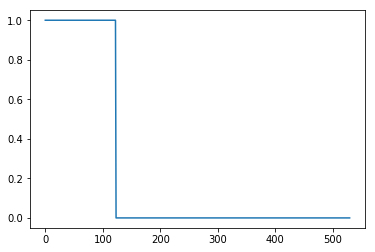

Random pick gives 76.79245283018868% 0


In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

data_labels = data.iloc[:,0]
plt.plot(data_labels)
plt.show()
zero_size = data[data_labels==0].shape[0]
sample_size = data.shape[0]
print("Random pick gives " + str(zero_size*100/sample_size) + "% 0")


Probably many columns dont have any data

In [0]:
data.columns[(data == 0).all()]

Index(['V4', 'V9', 'V10', 'V12', 'V14', 'V15', 'V16', 'V19', 'V21', 'V37',
       ...
       'V16530', 'V16531', 'V16533', 'V16536', 'V16537', 'V16538', 'V16554',
       'V16555', 'V16559', 'V16561'],
      dtype='object', length=5492)

# Dimensionality Reduction



The number of features is much more than the number of samples (so called curse of dimensioality). We need to reduce dimensions and keep only the statistial significant features. This is called Regularization and in this case the best model is L1 or **Lasso** Regression. In this case we start with **PCA**. Then try L1 penalized Logistic Regression

First separate Labels from Features

In [0]:
labels = data.iloc[:,0
features = data.iloc[:,1:]
print(features.values.shape)

(530, 16562)


Even though the data bounded to 0 and 1. We apply MinMax for the sake of reusing it for future data

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])
rescaled = scaler.fit_transform(features)

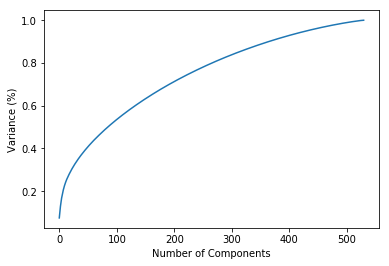

In [0]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

#Fitting the PCA algorithm with our Data
pca = PCA().fit(rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

We can pick only 200 components

In [0]:
pca = PCA(n_components=200)
dataset = pca.fit_transform(rescaled)
print(dataset.shape)

(530, 200)


# Data Preparation

**Important Note:** Here I split the data into training and test and use test to pick the best model. In real production we should not use test data for model selection or hyper parameter tunning and hide it from developers to be sure they don’t cheat. However for this homework I use test data as validation and assume there is another et of data hidden from me for testing.

In [0]:
from sklearn.model_selection import train_test_split
random_state = 42

train_unscaled,test_unscaled,y_train,y_test = train_test_split(dataset, labels, 
                        test_size=0.2, shuffle=True,
                         random_state=random_state)

Rescale the data and set it around 0 (We need it for SVM)

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(train_unscaled)
X_test = sc.transform(test_unscaled)


# Model Selection - Start with RF
This is the Binary Classification
Often the best model is RandomForest so lets start with it

In [174]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=15, max_depth=100,
                             random_state=random_state)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
y_pred_rf = rfc.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

In [177]:
print(y_pred_rf.shape)
print(y_pred_rf)

(106,)
[0.46666667 0.06666667 0.46666667 0.13333333 0.33333333 0.
 0.13333333 0.33333333 0.13333333 0.33333333 0.26666667 0.26666667
 0.66666667 0.2        0.13333333 0.06666667 0.         0.33333333
 0.33333333 0.4        0.13333333 0.         0.33333333 0.
 0.4        0.26666667 0.         0.13333333 0.33333333 0.4
 0.33333333 0.2        0.46666667 0.2        0.26666667 0.06666667
 0.06666667 0.         0.06666667 0.13333333 0.06666667 0.06666667
 0.06666667 0.2        0.33333333 0.06666667 0.06666667 0.13333333
 0.06666667 0.6        0.53333333 0.         0.2        0.6
 0.         0.46666667 0.13333333 0.06666667 0.26666667 0.13333333
 0.         0.26666667 0.33333333 0.33333333 0.33333333 0.06666667
 0.46666667 0.33333333 0.4        0.13333333 0.46666667 0.
 0.33333333 0.33333333 0.26666667 0.         0.33333333 0.26666667
 0.13333333 0.33333333 0.33333333 0.06666667 0.33333333 0.06666667
 0.         0.4        0.         0.06666667 0.4        0.
 0.4        0.46666667 0.26666667 

# Model Evaluation

For Classification AUC_ROC is the right metric to evaluate.
Lets first check the confusion matrix

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def print_model_performance(pred):
  pred = pred > 0.5
  print('Confusion Matric: \n', confusion_matrix(y_test,pred))
  print(classification_report(y_test,pred))
  print('Accuracy: ', accuracy_score(y_test, pred))
  #print('ROC AUC Score:', roc_auc_score(y_test, Y_score))


This is a classification so the real measurement of model is Aread Under Curve of ROC Curve

In [184]:
print_model_performance(y_pred_rf)

Confusion Matric: 
 [[73  1]
 [29  3]]
              precision    recall  f1-score   support

           0       0.72      0.99      0.83        74
           1       0.75      0.09      0.17        32

    accuracy                           0.72       106
   macro avg       0.73      0.54      0.50       106
weighted avg       0.73      0.72      0.63       106

Accuracy:  0.7169811320754716


# Another Model (SVM)

In [0]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', probability=True)


In [190]:
svc.fit(X_train, y_train)
y_pred_svc = svc.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_svc)
auc_svc = auc(fpr_svc, tpr_svc)
print_model_performance(y_pred_svc)

Confusion Matric: 
 [[71  3]
 [29  3]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.82        74
           1       0.50      0.09      0.16        32

    accuracy                           0.70       106
   macro avg       0.60      0.53      0.49       106
weighted avg       0.65      0.70      0.62       106

Accuracy:  0.6981132075471698


# Logistic Regression

In [193]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
y_pred_lr = LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)
print_model_performance(y_pred_lr)

Confusion Matric: 
 [[65  9]
 [13 19]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        74
           1       0.68      0.59      0.63        32

    accuracy                           0.79       106
   macro avg       0.76      0.74      0.74       106
weighted avg       0.79      0.79      0.79       106

Accuracy:  0.7924528301886793


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# L1 penalized Logistic Regression

I skip this part becuase this should be independent of PCA. I have already reduced the dimension to 200. Therefore Lasso won’t help much

# Naive Base (Gaussian)

In [195]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
nbg = GaussianNB()
nbg.fit(X_train, y_train)
y_pred_nbg = nbg.predict_proba(X_test)[:, 1]
fpr_nbg, tpr_nbg, thresholds_nbg = roc_curve(y_test, y_pred_nbg)
auc_nbg = auc(fpr_nbg, tpr_nbg)
print_model_performance(y_pred_nbg)

Confusion Matric: 
 [[61 13]
 [19 13]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        74
           1       0.50      0.41      0.45        32

    accuracy                           0.70       106
   macro avg       0.63      0.62      0.62       106
weighted avg       0.68      0.70      0.69       106

Accuracy:  0.6981132075471698


So far Logistic Regression had the best Score.
Let’s try NN

# Neural Network model

In [0]:
from keras.models import Sequential
from keras.layers import Dense

def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=200, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [168]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 80.66% (3.91%)


In [178]:
keras_model = create_baseline()
keras_model.fit(X_train, y_train, epochs=20, batch_size=3, verbose=0)


In [0]:
from sklearn.metrics import roc_curve

y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

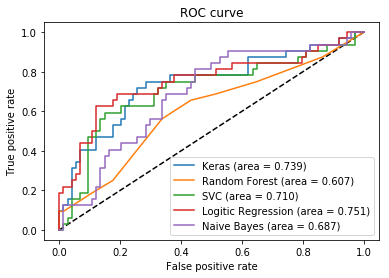

In [199]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_svc, tpr_svc, label='SVC (area = {:.3f})'.format(auc_svc))
plt.plot(fpr_lr, tpr_lr, label='Logitic Regression (area = {:.3f})'.format(auc_lr))
plt.plot(fpr_nbg, tpr_nbg, label='Naive Bayes (area = {:.3f})'.format(auc_nbg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


We should be able to figure out the threshold corresponding to the highest AUC and then calculate the accuracy and it should pass 0.8 for Logistic Regression and maybe if we add dropout or even Conv1D get better result for Keras model.